## Run the full end-to-end pipeline

In [1]:
from src.neuralnet import NeuralNetwork
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from tkinter import Tk, Canvas, Button, LEFT, RIGHT, BOTH, YES
from PIL import Image, ImageDraw, ImageTk
import os
import numpy as np
import kagglehub
import patoolib
import torch
import torchvision
from torchvision.transforms import v2
from levycas import parse, integrate, Variable

First, trained model is loaded from saved checkpoint

In [2]:
# load model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "model.pth"

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = NeuralNetwork().to(DEVICE)
model.load_state_dict(checkpoint['model_state']);

# load data
path = kagglehub.dataset_download("xainano/handwrittenmathsymbols")

# Extract .rar. Note that this requires unrar to be installed
# - sudo apt install unrar
patoolib.extract_archive(path + "/data.rar", outdir=path + "/data/")
DATA_PATH = f"{path}/data/extracted_images/"

transformations = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale(),
    v2.Normalize((0.5,), (0.5,)) #Transform values [0, 1] -> [-1, 1] 
])

dataset = torchvision.datasets.ImageFolder(
    root=DATA_PATH,
    transform=transformations,
)

INFO patool: Extracting /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar
INFO patool: ... /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar extracted to `/home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data/'.


Here, we set up the image processing pipeline that allows us to read in handwritten images.
- Necessary to convert the user images into a format that the model will recognize!

In [3]:


class ImageProcessor:
    """Input processing pipeline:
        
            1. Fetch image
            2. Symbol isolation
            3. Image preprocessing
            4. CNN classification
            5. Equation parsing
    """
    def __init__(self, model):
        self.model = model.cpu()

    def process(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        #1. Isolate Symbols
        symbols = self.isolate_symbols(img)
        self.visualize_syms(symbols)

        #2. Preprocess Symbols
        symbol_tensor = self.preprocess_symbols(symbols)
        self.visualize_preprocessed(symbol_tensor)
        
        #3 Classification
        predictions = self.classify_symbols(symbol_tensor)
        classes = [dataset.classes[p.item()] for p in predictions]
        return classes

    def isolate_symbols(self, img):
        """Use contours to identify the bounding boxes of each symbol -> list of np.ndarrays"""

        # Binarize (black background, white symbols)
        _, binarized = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

        # Extract contours
        contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        symbols = []
        x_coords = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Crop symbol
            symbol = binarized[y:y+h, x:x+w]
            symbols.append(symbol)
            x_coords.append(x)

        # Sort by x-coord of contour
        symbols = [sym for _, sym in sorted(zip(x_coords, symbols), key=lambda b: b[0])]        
        return symbols

    def visualize_syms(self, symbols):
        """Helper tool to visualize each symbol"""
        cols = 4
        rows = (len(symbols) + cols - 1) // cols  # number of rows
        plt.figure(figsize=(cols, rows))
    
        for i, symbol in enumerate(symbols):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(symbol, cmap="gray")
            plt.suptitle("Segmented Symbols")
            plt.axis("off")
    
        plt.tight_layout()
        plt.show()
        
    def preprocess_symbols(self, symbols):
        """Turn each 45x45 symbol into a tensor of shape [N, 1, 45, 45]"""
        processed = []

        for symbol in symbols:
            #1. Resize
            h, w = symbol.shape
            scale = min(45 / h, 45 / w)
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(symbol, (new_w, new_h), interpolation=cv2.INTER_AREA)

            #2. Place onto a 45x45 white background
            bg = np.ones((45, 45), dtype=np.float32) * 0
            x_off = (45 - new_w) // 2
            y_off = (45 - new_h) // 2
            bg[y_off:y_off+new_h, x_off:x_off+new_w] = resized
            
            #3. Normalize to (-1, 1), invert
            _, bg = cv2.threshold(bg, 127, 255, cv2.THRESH_BINARY_INV)
            canvas = (bg.astype(np.float32) / 127.5) - 1.0

            #4. Convert to Tensor of shape [1, 1, 45, 45]
            sym_tensor = torch.from_numpy(bg).unsqueeze(0).float() / 255.0      # [0, 1]
            sym_tensor = (sym_tensor - 0.5) / 0.5                              # [-1, 1]
            
            processed.append(sym_tensor)

        return torch.stack(processed, dim=0)

    def visualize_preprocessed(self, sym_tensor, cols=8):
        """Helper tool to visualize the preprocessed images"""
        # print(f"Symbols Batch has shape {sym_tensor.shape}")
        imgs = sym_tensor.clone().cpu()

        # Undo normalization: [-1,1] -> [0,1] for display
        imgs = (imgs * 0.5) + 0.5  
    
        N = imgs.shape[0]
        rows = (N + cols - 1) // cols
    
        plt.figure(figsize=(cols * 1.5, rows * 1.5))
        for i in range(N):
            plt.subplot(rows, cols, i+1)
            plt.imshow(imgs[i,0].numpy(), cmap="gray")
            plt.axis("off")
    
    
        plt.suptitle("Final Preprocessed Symbols")
        plt.subplots_adjust(top=0.88)
        plt.tight_layout()
        plt.show()
    
    def classify_symbols(self, symbol_tensor):
        """Run each symbol through the CNN to classify"""
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(symbol_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
        return predictions

#### Let's start the pipeline!
- First, we'll load well-posed sample images from `user_images/`

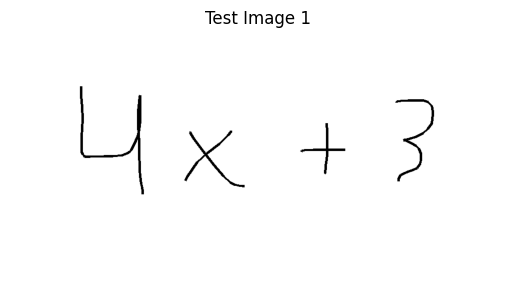

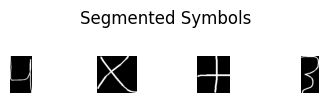

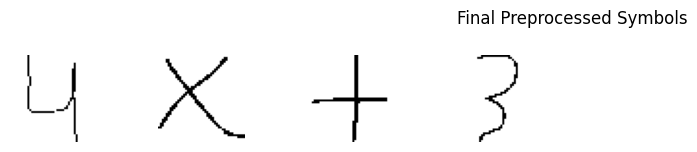

Idenfitied 4 symbols
Classified Expression: 4X+3
Succesfully parsed as 3 + 4X
Your expression integrates to: 3X + 2X²


In [4]:
tester = ImageProcessor(model)

test1_path = "user_images/test1.png"
test_img1 = cv2.imread(test1_path)

plt.imshow(test_img1)
plt.axis('off')
plt.title("Test Image 1")
plt.show()
identified_syms = tester.process(test1_path)
classified_syms = ''.join(identified_syms)
print(f"Idenfitied {len(identified_syms)} symbols")
print(f"Classified Expression: {classified_syms}")

try:
    parsed = parse(classified_syms)
    print(f"Succesfully parsed as {parsed}")
    integral = str(integrate(parsed, Variable('X')))
    print(f"Your expression integrates to: {integral}")
except Exception as e:
    print(f"Could not parse...")
    print(e)

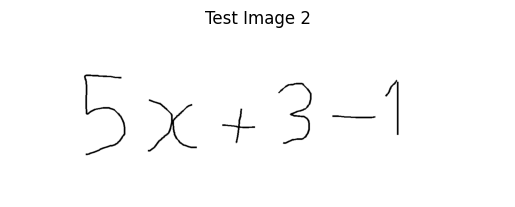

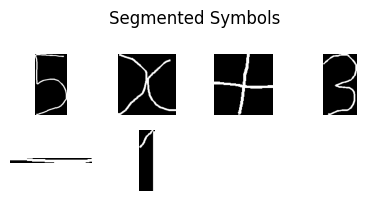

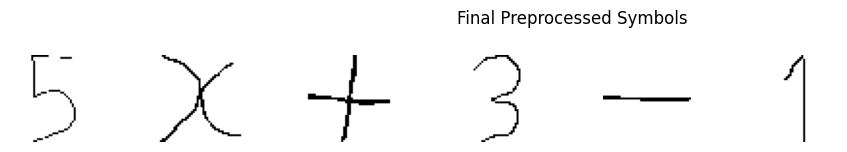

Idenfitied 6 symbols
Classified Expression: 5X+3-1
Succesfully parsed as 2 + 5X
Your expression integrates to: 2X + (5/2)X²


In [5]:
test2_path = "user_images/test2.png"
test_img2 = cv2.imread(test2_path)

plt.imshow(test_img2)
plt.axis('off')
plt.title("Test Image 2")
plt.show()
identified_syms = tester.process(test2_path)
classified_syms = ''.join(identified_syms)
print(f"Idenfitied {len(identified_syms)} symbols")
print(f"Classified Expression: {classified_syms}")

try:
    parsed = parse(classified_syms)
    print(f"Succesfully parsed as {parsed}")
    integral = str(integrate(parsed, Variable('X')))
    print(f"Your expression integrates to: {integral}")
except Exception as e:
    print(f"Could not parse...")
    print(e)

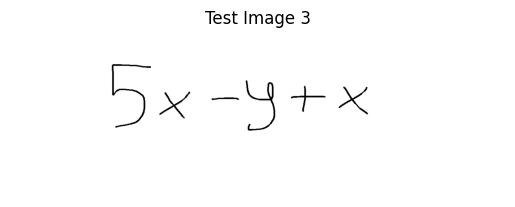

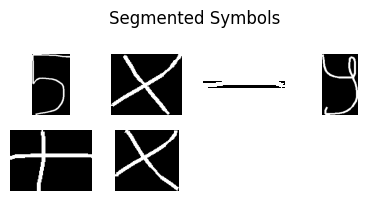

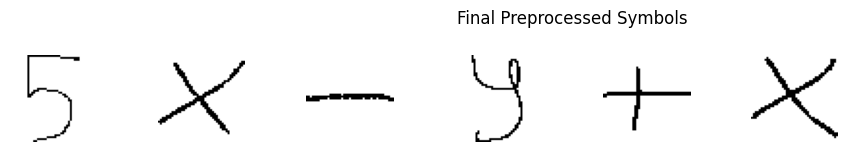

Idenfitied 6 symbols
Classified Expression: 5X-y+X
Succesfully parsed as 6X - y
Your expression integrates to: 3X² - yX


In [6]:
test3_path = "user_images/test3.png"
test_img3 = cv2.imread(test3_path)

plt.imshow(test_img3)
plt.axis('off')
plt.title("Test Image 3")
plt.show()
identified_syms = tester.process(test3_path)
classified_syms = ''.join(identified_syms)
print(f"Idenfitied {len(identified_syms)} symbols")
print(f"Classified Expression: {classified_syms}")

try:
    parsed = parse(classified_syms)
    print(f"Succesfully parsed as {parsed}")
    integral = str(integrate(parsed, Variable('X')))
    print(f"Your expression integrates to: {integral}")
except Exception as e:
    print(f"Could not parse...")
    print(e)

Next, we set up the canvas that will allow the user's drawings to feed directly to the classifier.

In [7]:
CANVAS_W, CANVAS_H = 1500, 500
BACKGROUND = (255, 255, 255)
PEN_COLOR = (0, 0, 0) 
PEN_WIDTH = 12  

class InputCanvas:
    def __init__(self, model, out_dir="user_images", save_path="input.png"):
        self.out_dir = out_dir
        self.save_path = save_path
        
        self.last_x = None
        self.last_y = None
        self.drawing_image = Image.new("RGB", (CANVAS_W, CANVAS_H), BACKGROUND)
        self.draw = ImageDraw.Draw(self.drawing_image)
        self.root = Tk()
        self.root.title("Input Math Expression")

        self.canvas = Canvas(self.root, width=CANVAS_W, height=CANVAS_H, bg="white")
        self.canvas.pack(expand=YES, fill=BOTH)

        self.canvas.bind("<Button-1>", self.set_start)
        self.canvas.bind("<B1-Motion>", self.draw_line)
        self.canvas.bind("<ButtonRelease-1>", self.end_line)

        self.btn_frame_left = Button(self.root, text="Clear", command=self.clear_canvas)
        self.btn_frame_left.pack(side=LEFT, padx=8, pady=8)

        self.btn_frame_save = Button(self.root, text="Submit", command=self.submit_input)
        self.btn_frame_save.pack(side=RIGHT, padx=8, pady=8)

        self.processor = ImageProcessor(model)

    def set_start(self, event):
        """Start a new line on click"""
        self.last_x, self.last_y = event.x, event.y
    
    def draw_line(self, event):
        """Draw line from previous coord; update coords"""
        x, y = event.x, event.y
        if self.last_x is not None and self.last_y is not None:
            # Draw on the tkinter canvas
            self.canvas.create_line(self.last_x, self.last_y, x, y,
                               width=PEN_WIDTH,
                               capstyle="round",
                               smooth=True,
                               splinesteps=36,
                               fill="black")
            
            # Draw on the PIL image
            self.draw.line([(self.last_x, self.last_y), (x, y)], fill=PEN_COLOR, width=5)
        self.last_x, self.last_y = x, y
    
    def end_line(self, event=None):
        """End line on button-up"""
        self.last_x, self.last_y = None, None
    
    def clear_canvas(self):
        """Clear both canvases"""
        self.canvas.delete("all")
        self.drawing_image = Image.new("RGB", (CANVAS_W, CANVAS_H), BACKGROUND)
        self.draw = ImageDraw.Draw(self.drawing_image)
    
    def submit_input(self):
        """Starts input processing pipeline"""
        self.save_img()
        classified_syms = self.processor.process(os.path.join(self.out_dir, self.save_path))
        segmented_syms = ''.join(classified_syms)
        print(f"Classified: {segmented_syms}")
        try:
            parsed = parse(segmented_syms)
            integral = integrate(parsed, Variable('X'))
            print(f"The integral of your expression is: {integral}")
        except Exception as e:
            print("Could not parse/integrate your expression...")
            print(e)
        
    def save_img(self):
        """Save canvas to disk"""
        os.makedirs(self.out_dir, exist_ok=True)
    
        # Save raw drawing
        raw_path = os.path.join(self.out_dir, self.save_path)
        self.drawing_image.save(raw_path)

    def start(self):
        self.root.mainloop()

#### Now, we test with user input!
- You should see a popup canvas immediately. If nothing appears, please ensure that you have TKinter correctly installed with your python installation.

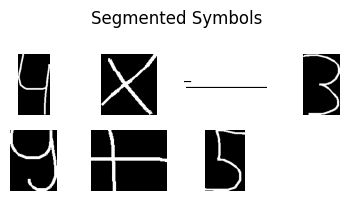

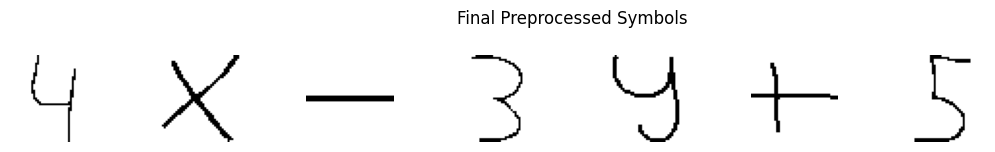

Classified: 4X-3y+S
The integral of your expression is: XS + 2X² - 3yX


In [14]:
input_canvas = InputCanvas(model)
input_canvas.start()